<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/main/MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке развивается предсказатель высшей точки. Его цель - предсказывать, что мы находимя в локлаьном максимуме - цены выше на заданном горизонте в будущем не будет

In [3]:
#!pip install yfinance

In [1]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
%matplotlib inline

In [2]:
from methods import *

# Готовим данные

In [3]:
stocks = load_data("MSFT", period_start="2021-01-01", step="1d")
print(stocks.shape[0])
stocks.head()

[*********************100%***********************]  1 of 1 completed
298


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,220.224826,220.689959,212.584796,215.434967,37130100
2021-01-05,215.009422,216.256380,213.465584,215.642792,23823000
2021-01-06,209.972127,214.247383,209.744514,210.051300,35930700
2021-01-07,211.822773,217.067874,211.496205,216.028748,27694500
2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200


## Размечаем таргет

Размечаем таргет...


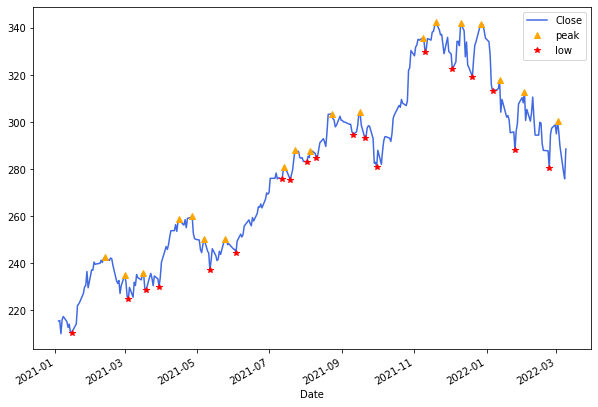

In [4]:
print("Размечаем таргет...")
mark_data_targets(stocks, window=10)

# отрисовываем график таргеты
stocks["Close"].plot(figsize=[10,7], color="royalblue")
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak", color="orange")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low", color="red")

_ = plt.legend()

## Расчитываем скользящие средние (СС)

Рассчитываем скользящие средние...


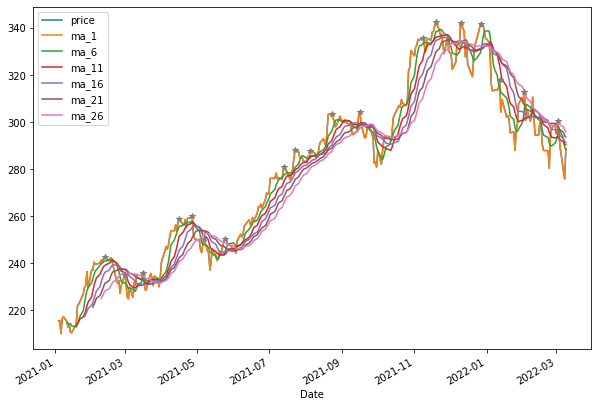

In [5]:
print("Рассчитываем скользящие средние...")
stocks_ma = create_ma(stocks["Close"], ma_steps=np.arange(1, 30, 5))

# Отрисовывем на обучении
_ = stocks_ma.plot(figsize=[10,7])
_ = stocks.loc[stocks["peaks"]==1, "Close"].plot(style="*")

## Отловим сигналы по СС

In [6]:
sell_signals, buy_signals = form_signals(stocks_ma)

In [7]:
buy_signals.sum(axis=0)

ma_1_ma_6_buy_signal      51
ma_1_ma_11_buy_signal     34
ma_1_ma_16_buy_signal     28
ma_1_ma_21_buy_signal     26
ma_1_ma_26_buy_signal     23
ma_6_ma_11_buy_signal     27
ma_6_ma_16_buy_signal     17
ma_6_ma_21_buy_signal     14
ma_6_ma_26_buy_signal     13
ma_11_ma_16_buy_signal    17
ma_11_ma_21_buy_signal    13
ma_11_ma_26_buy_signal    12
ma_16_ma_21_buy_signal    15
ma_16_ma_26_buy_signal    12
ma_21_ma_26_buy_signal    14
dtype: int64

## Разделение на обучение и тест

In [8]:
train_size = int(stocks_ma.shape[0]*2/3)
stocks_ma_train = stocks_ma[:train_size].copy(deep=True)
stocks_ma_test = stocks_ma[train_size:].copy(deep=True)

# Обучение

## Выбираем какая пара СС лучше предсказывает


In [9]:
from tqdm import tqdm

In [10]:
#перебираем различные комбинации поиска сигналов на продажу и сигналов на покупку
ss_bs_chose_data = pd.DataFrame()
ss_bs_chose_data["price"] = stocks_ma_train["price"] 
ma_results = dict()

for ss_name in tqdm(sell_signals.columns):
  ss_bs_chose_data["sell_signal"] = np.NaN
  ss_bs_chose_data.loc[sell_signals[ss_name]>0, "sell_signal"] = ss_bs_chose_data.loc[sell_signals[ss_name]>0, "price"]
  
  for bs_name in buy_signals.columns: 
    ss_bs_chose_data["buy_signal"] = np.NaN
    ss_bs_chose_data.loc[buy_signals[bs_name]>0, "buy_signal"] = ss_bs_chose_data.loc[buy_signals[bs_name]>0, "price"] 
    money_hist, money, eq = validate(ss_bs_chose_data, start_money = 10000, verbose=0)
    ma_results[ss_name+"+"+bs_name] = money

100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


In [11]:
ma_results_pd = pd.DataFrame.from_dict(ma_results, orient="index", columns=["result"])
ma_results_pd.sort_values(by="result", ascending=False).head()

,result
ma_6_ma_21_sell_signal+ma_1_ma_6_buy_signal,13664.440231
ma_11_ma_26_sell_signal+ma_1_ma_6_buy_signal,13595.369064
ma_16_ma_26_sell_signal+ma_1_ma_6_buy_signal,13582.542313
ma_6_ma_26_sell_signal+ma_1_ma_6_buy_signal,13458.425964
ma_11_ma_16_sell_signal+ma_1_ma_6_buy_signal,13420.791641


In [12]:
chosen_sell_signals, chosen_buy_signals = ma_results_pd.sort_values(by="result", ascending=False).index.values[0].split("+")

In [13]:
#chosen_sell_signals = "ma_5_ma_10_sell_signal"
#chosen_buy_signals = "ma_5_ma_10_buy_signal"

In [14]:
print(chosen_sell_signals)
print(chosen_buy_signals)

ma_6_ma_21_sell_signal
ma_1_ma_6_buy_signal


# Применяем выбранные СС

In [15]:
train_data = apply_strategy(stocks_ma_train, 
               sell_signals=sell_signals, buy_signals = buy_signals,
               chosen_sell_signals = chosen_sell_signals, chosen_buy_signals=chosen_buy_signals)

test_data = apply_strategy(stocks_ma_test, 
               sell_signals=sell_signals, buy_signals = buy_signals,
               chosen_sell_signals = chosen_sell_signals, chosen_buy_signals=chosen_buy_signals)

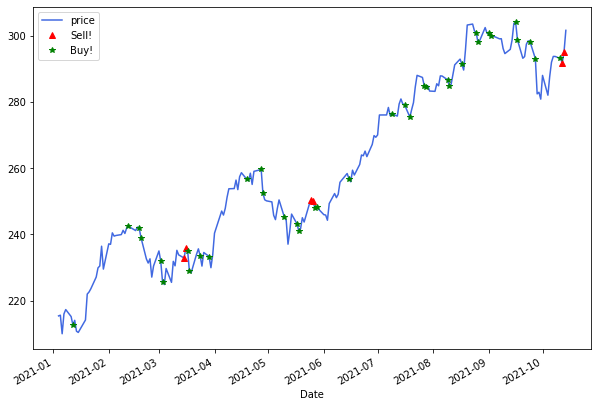

In [16]:
train_data["price"].plot(figsize=[10,7], color="royalblue")
train_data.loc[~np.isnan(train_data["sell_signal"]), "price"].plot(style="^", label="Sell!", color="red")
train_data.loc[~np.isnan(train_data["buy_signal"]), "price"].plot(style="*", label="Buy!", color="green")
plt.legend()

# Валидация стратегии

In [17]:
money_hist_train, money_train, eq_train = validate(train_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-01-12 00:00:00: Покупаем 47.0  по цене 212.70355224609375, остаток средств: 2.93304443359375
2021-02-12 00:00:00: Покупаем 0.0  по цене 242.45216369628906, остаток средств: 2.93304443359375
2021-02-18 00:00:00: Покупаем 0.0  по цене 241.8202667236328, остаток средств: 2.93304443359375
2021-02-19 00:00:00: Покупаем 0.0  по цене 239.0230712890625, остаток средств: 2.93304443359375
2021-03-02 00:00:00: Покупаем 0.0  по цене 231.9804229736328, остаток средств: 2.93304443359375
2021-03-03 00:00:00: Покупаем 0.0  по цене 225.7213897705078, остаток средств: 2.93304443359375
2021-03-15 00:00:00: Продаём 47.0  по цене 232.91282653808594, остаток средств: 10949.835891723633
2021-03-17 00:00:00: Покупаем 46.0  по цене 235.12481689453125, остаток средств: 134.0943145751953
2021-03-18 00:00:00: Покупаем 0.0  по цене 228.8558807373047, остаток средств: 134.0943145751953
2021-03-24 00:00:00: Покупаем 0.0  по цене 233.5575714111328, остаток средств: 134.09431457519

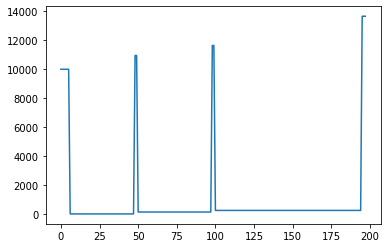

In [18]:
plt.plot(money_hist_train)

In [19]:
money_hist_test, money_test, eq_test = validate(test_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-10-22 00:00:00: Покупаем 32.0  по цене 307.9586486816406, остаток средств: 145.3232421875
2021-11-09 00:00:00: Покупаем 0.0  по цене 334.6445617675781, остаток средств: 145.3232421875
2021-11-10 00:00:00: Покупаем 0.0  по цене 329.5145568847656, остаток средств: 145.3232421875
2021-11-22 00:00:00: Покупаем 0.0  по цене 339.1287536621094, остаток средств: 145.3232421875
2021-11-23 00:00:00: Покупаем 0.0  по цене 336.98321533203125, остаток средств: 145.3232421875
2021-12-13 00:00:00: Покупаем 0.0  по цене 338.69964599609375, остаток средств: 145.3232421875
2021-12-13 00:00:00: Продаём 32.0  по цене 338.69964599609375, остаток средств: 10983.7119140625
2021-12-14 00:00:00: Покупаем 33.0  по цене 327.6624755859375, остаток средств: 170.8502197265625
2021-12-14 00:00:00: Продаём 33.0  по цене 327.6624755859375, остаток средств: 10983.7119140625
2021-12-30 00:00:00: Покупаем 32.0  по цене 338.6198425292969, остаток средств: 147.876953125
2021-12-31 00:00

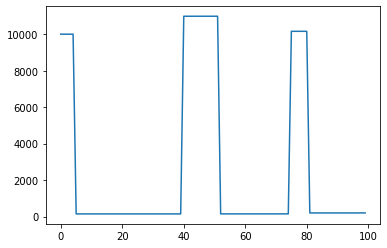

In [20]:
plt.plot(money_hist_test)